# Fitting Signal Detection Measures to ROC Curves

In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from sklearn.utils import check_consistent_length
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Functions

In [2]:
def compute_dprime(tp, fp):
    return stats.norm.ppf(tp) - stats.norm.ppf(fp)


def compute_c_bias(tp, fp):
    return - 0.5 * (stats.norm.ppf(tp) + stats.norm.ppf(fp))


def to_freq(*arrays):
    # Better version of `convert_to_freq()`
    out = []
    for a in arrays:
        converted = np.array([(x + i / len(a)) / (max(a)+1) for i, x in enumerate(a, start=1)])
        out.append(converted)
    return out


def g_squared_dual_process(x, x_freq, expected, x_max):
    # Better version, supports vectorisation
    a = 2 * x * np.log(x_freq / expected) 
    b = 2 * (x_max - x) * np.log((1 - x_freq) / (1 - expected))
    return a + b


def dual_process_model(parameters, labels, signal, noise):
    # Better than the first, vectorised
    
    # length of parameters must equal length of labels
    assert len(parameters) == len(labels), print(f"Length of parameters ({len(parameter)}) different from length of labels ({len(labels)}).")
    
    # Ensure signal and noise are numpy arrays
    parameters, labels = np.array(parameters), np.array(labels)
    signal, noise = np.array(signal), np.array(noise)
    # Ensure they are equal length
    check_consistent_length(signal, noise)
    
    # Grab the R and d values
    R = parameters[labels == 'R'].item()
    d = parameters[labels == 'd'].item()
    # Grab the c values
    c_values = parameters[(labels!='R') & (labels!='d')]
    
    # Accumulate the signal and noise data
    signal_c, noise_c = np.cumsum(signal), np.cumsum(noise)
    
    # Get the expected values for signals and noises
    exp_signal = R + (1 - R) * stats.norm.cdf(d / 2 - c_values)
    exp_noise = stats.norm.cdf(-d / 2 - c_values)
    
    # Get frequencies for the cumulative signal and noise
    signal_f, noise_f = to_freq(signal_c, noise_c)
    
    # Compute the expected frequencies for signal and noise
    exp_signal = R + (1 - R) * stats.norm.cdf(d / 2 - c_values)
    exp_noise = stats.norm.cdf(-d / 2 - c_values)

    # Compute the gsquared using the dual process model parameters
    #   Still getting runtime warnings about division. Function only works with numpy, so can't use math.
    signal_gsquared = g_squared_dual_process(x=signal_c[:-1], x_freq=signal_f[:-1], expected=exp_signal, x_max=signal_c.max())
    noise_gsquared = g_squared_dual_process(x=noise_c[:-1], x_freq=noise_f[:-1], expected=exp_noise, x_max=noise_c.max())
    g_squared_summed = np.sum([signal_gsquared, noise_gsquared])
    
    return g_squared_summed

## Testing

In [3]:
signal = [508,224,172,135,119,63] # Signal present examples
noise = [102,161,288,472,492,308] # Signal absent examples
labels = np.array(['R', 'd', 'c1', 'c2', 'c3', 'c4', 'c5'])
# parameters = np.random.uniform(0.25, 0.75, len(labels))
iterations = 50

for i in range(iterations):
    try:
        parameters = np.random.uniform(0.25, 0.75, len(labels))
        opt = minimize(fun=dual_process_model, x0=parameters, args=(labels, signal, noise), tol=1e-4)
        if opt.success:
            # Converged at (local?) minimum.
            break
        else:
            raise ValueError("Optimisation unsuccessful")
    except:
        print(f"Failure on iteration {i}, trying again...")
        
opt

      fun: 22.610900467594025
 hess_inv: array([[ 0.00051274, -0.00124161,  0.0005865 ,  0.00048503,  0.00060602,
         0.00041769,  0.00072408],
       [-0.00124161,  0.00366373, -0.00148186, -0.00126668, -0.00166372,
        -0.00113   , -0.00205172],
       [ 0.0005865 , -0.00148186,  0.00146456,  0.00052447,  0.0007057 ,
         0.00052884,  0.00090958],
       [ 0.00048503, -0.00126668,  0.00052447,  0.00088932,  0.00060032,
         0.00044096,  0.00077326],
       [ 0.00060602, -0.00166372,  0.0007057 ,  0.00060032,  0.00109695,
         0.00053351,  0.00094944],
       [ 0.00041769, -0.00113   ,  0.00052884,  0.00044096,  0.00053351,
         0.00066806,  0.00059014],
       [ 0.00072408, -0.00205172,  0.00090958,  0.00077326,  0.00094944,
         0.00059014,  0.0015598 ]])
      jac: array([-3.86238098e-05, -2.28881836e-05,  6.67572021e-06,  1.76429749e-05,
       -6.67572021e-06, -1.19209290e-05,  3.24249268e-05])
  message: 'Optimization terminated successfully.'
     n

### Visualise the results

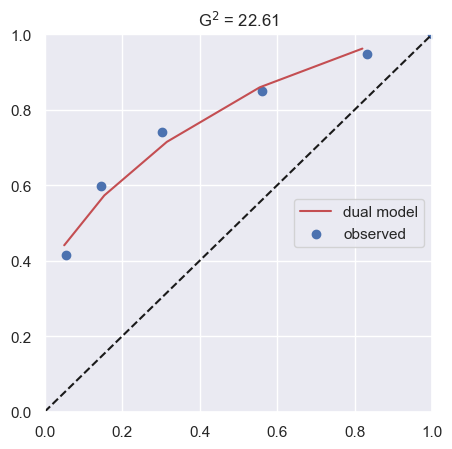

AUC for data = 0.76


In [4]:
result = dict(opt)

opt_parameters = result['x']
GoF = result['fun']

R = opt_parameters[0]
d = opt_parameters[1]
c_values = opt_parameters[2:]

y_obs, x_obs = to_freq(np.cumsum(signal), np.cumsum(noise))

# Get the expected values for signals and noises
y_fitted = R + (1 - R) * stats.norm.cdf(d / 2 - c_values)
x_fitted = stats.norm.cdf(-d / 2 - c_values)

fig, ax = plt.subplots(figsize=(5,5), dpi=100)
ax.plot([0,1], [0,1], ls='dashed', c='k')
ax.plot(x_fitted, y_fitted, label='dual model', c='r')
ax.scatter(x_obs, y_obs, label='observed')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(loc='center right')
ax.set_title('G$^2$ = ' + str(round(GoF, 2)))
plt.show()

auc = (np.trapz(y_obs, x_obs))
print(f"AUC for data = {auc:.2f}")